# Bert baseline for POLAR

## Subtask 1 - Polarization detection

This is a binary classification to determine whether a post contains polarized content (Polarized or Not Polarized).

In [1]:
!unzip dev_phase.zip

unzip:  cannot find or open dev_phase.zip, dev_phase.zip.zip or dev_phase.zip.ZIP.


In [2]:
!pip install wandb -qU

In [3]:
import wandb
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aimeloick (paderborn-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Imports

In [4]:
import pandas as pd
import re
from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np
from sklearn.model_selection import train_test_split
import torch

from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

In [5]:
from google.colab import userdata
#userdata.get('wandb')

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


## Data Import

The training data consists of a short text and binary labels

The data is structured as a CSV file with the following fields:
- id: a unique identifier for the sample
- text: a sentence or short text
- polarization:  1 text is polarized, 0 text is not polarized

The data is in all three subtask folders the same but only containing the labels for the specific task.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip /content/drive/MyDrive/dev_phase.zip

In [9]:
# Load the training and validation data for subtask 1

data = pd.read_csv('/content/drive/MyDrive/subtask1/train/eng.csv')
dev = pd.read_csv('/content/drive/MyDrive/subtask1/dev/eng.csv')

data.head()

,id,text,polarization
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0


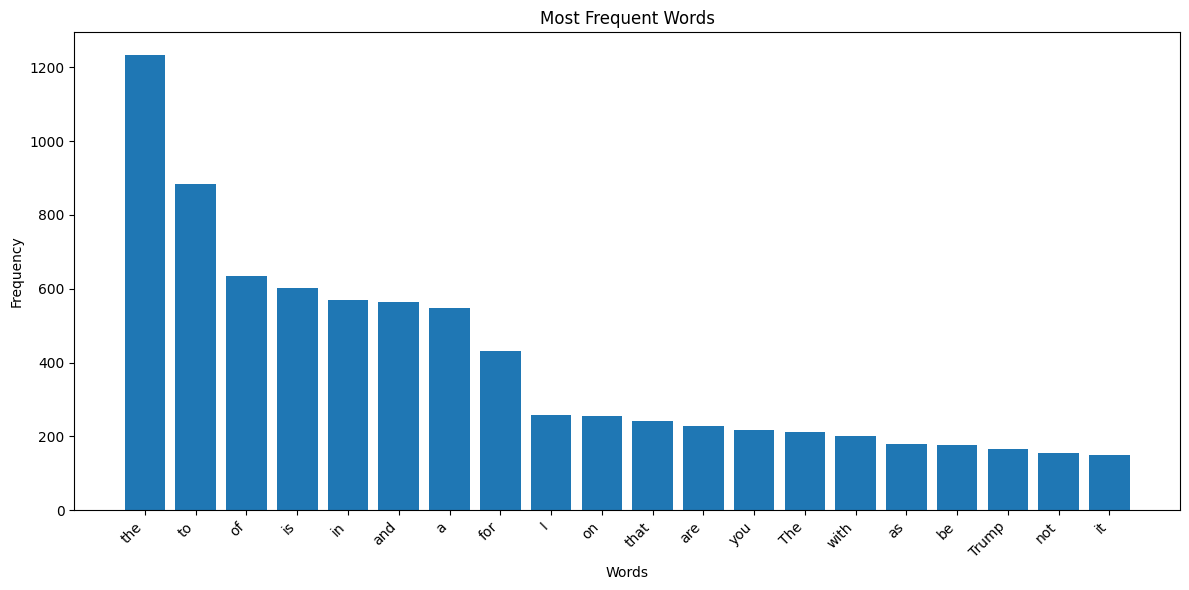

In [11]:
from collections import Counter

import matplotlib.pyplot as plt

# ---- 3. Count the words ----

# Set all_words from the cleaned text in the DataFrame 'data'

# This assumes that the DataFrame 'data' is available and that its 'text' column is cleaned.

# If 'data' is not available or has not been cleaned, this line may need to be modified.

all_words = [word for text in data['text'].dropna() for word in str(text).split()]

counter = Counter(all_words)
most_frequent = counter.most_common(20) # the 20 most frequent words

words = [w for w, c in most_frequent]

counts = [c for w, c in most_frequent]

# ---- 4. Graph ----
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xticks(rotation=45, ha="right")
plt.title("Most Frequent Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

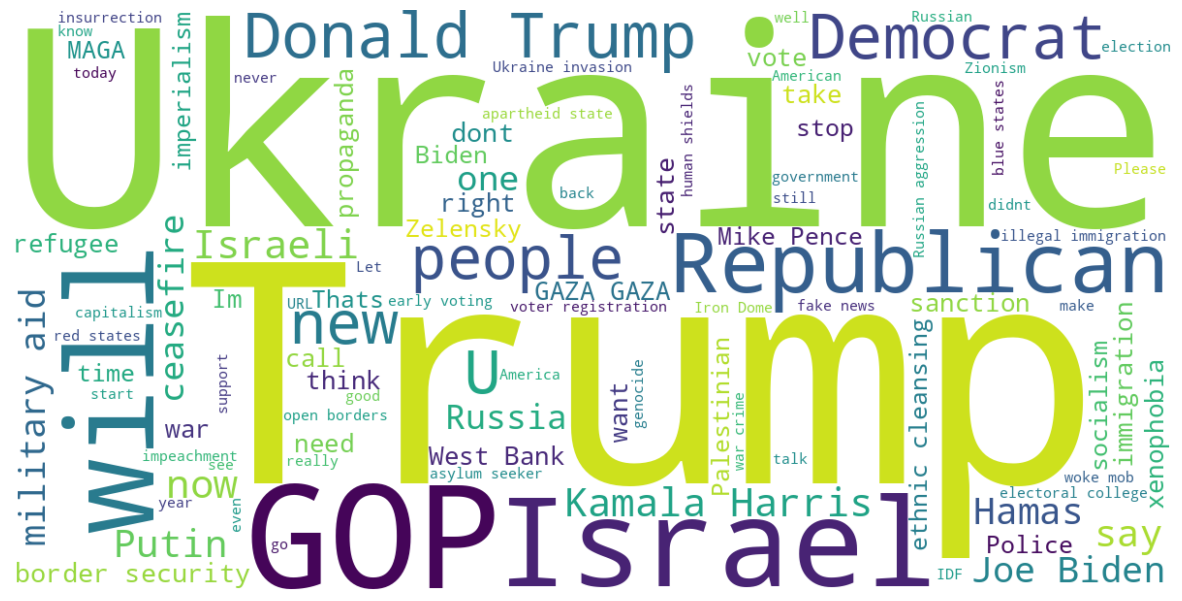

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'data' DataFrame contains the text, and the cleaned text is in the 'text' column
all_text = " ".join(data["text"].dropna())

# ---- 3. Générer le Word Cloud ----
wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=100
).generate(all_text)

# ---- 4. Afficher ----
plt.figure(figsize=(15, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [13]:
data[data["polarization"] == 0].head(10)

,id,text,polarization
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0
5,eng_bb7b41ffa6c56b52f8bbeb21a4c7aa77,"""Enemy of the people"" was a phrase coined and ...",0
6,eng_3a6672eb8e74090ad8884ee4f3343dc0,"""He also voiced support for Elon Musk, Tommy R...",0
7,eng_2c77bd1f661480f247fad599ac99bd17,"""If you disagree with imperialism, youre a sup...",0
8,eng_3b91189f79ee9b5423000bb60460491b,"""italian"" as a national identity is totally ov...",0
9,eng_c39ae8ec15297d3528d8c2a5dd7e2753,"""No to ethnic cleansing"". QudsDay QudsMainIssue",0


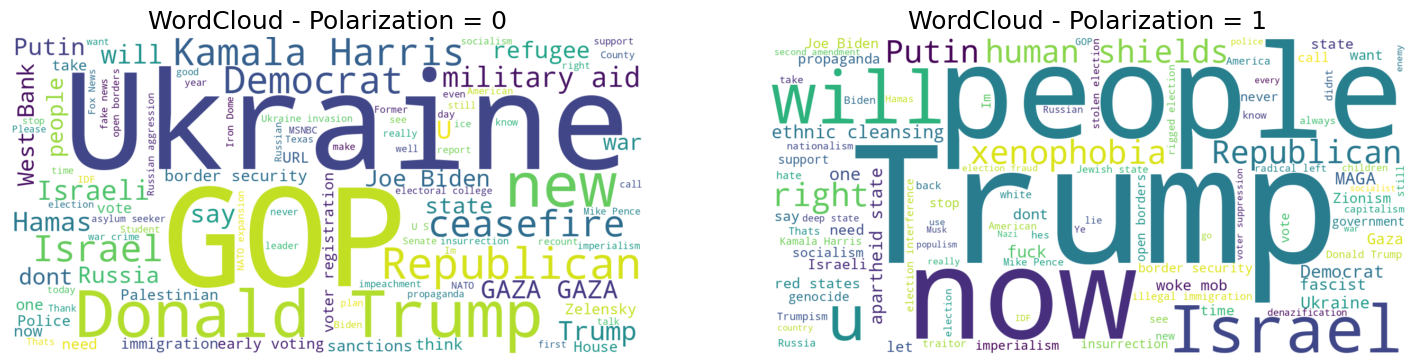

In [14]:
# ---- 2. Split text by polarization class ----
text_0 = " ".join(data[data["polarization"] == 0]['text'].dropna())
text_1 = " ".join(data[data["polarization"] == 1]['text'].dropna())

# ---- 3. Generate word clouds ----
wc0 = WordCloud(width=1200, height=600, background_color="white", max_words=100).generate(text_0)
wc1 = WordCloud(width=1200, height=600, background_color="white", max_words=100).generate(text_1)

# ---- 4. Plot side by side ----
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc0, interpolation="bilinear")
plt.title("WordCloud - Polarization = 0", fontsize=18)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wc1, interpolation="bilinear")
plt.title("WordCloud - Polarization = 1", fontsize=18)
plt.axis("off")

plt.show()

# Dataset
-  Create a pytorch class for handling data
-  Wrapping the raw texts and labels into a format that Huggingface’s Trainer can use for training and evaluation

In [15]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
  def __init__(self, texts, tokenizer, labels=None, max_length=128):
    self.texts = texts
    self.labels = labels # labels can be None
    self.tokenizer = tokenizer
    self.max_length = max_length # Store max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self,idx):
    text=self.texts[idx]
    encoding=self.tokenizer(text,truncation=True,padding=False,max_length=self.max_length,return_tensors='pt')

    # Ensure consistent tensor conversion for all items
    item = {key: encoding[key].squeeze() for key in encoding.keys()}
    if self.labels is not None: # Only add labels if provided
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
    return item

Now, we'll tokenize the text data and create the datasets using `bert-base-uncased` as the tokenizer.

In [16]:
import re


def clean_text(t):
    t = t.lower()
    t = re.sub(r"http\S+|www\S+", "", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

In [17]:
data = data.copy()
dev = dev.copy()
data["text"] = data["text"].apply(clean_text)
dev["text"] = dev["text"].apply(clean_text)


In [18]:
train, val = train_test_split(data, test_size=0.15, random_state=2, stratify=data['polarization'])


In [19]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# Create datasets
train_dataset = PolarizationDataset(data['text'].tolist(), tokenizer, labels=data['polarization'].tolist())
val_dataset = PolarizationDataset(val['text'].tolist(), tokenizer, labels=val['polarization'].tolist())
dev_dataset = PolarizationDataset(dev['text'].tolist(), tokenizer, labels=None)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

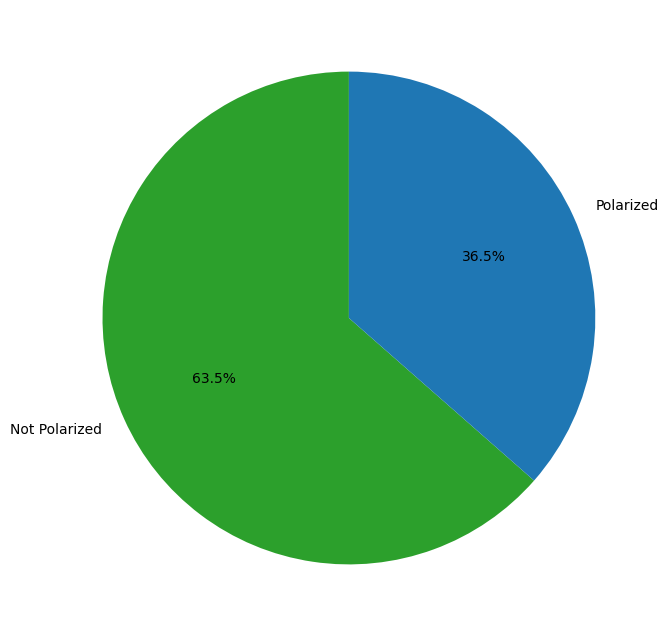

In [25]:
# Compter les classes
polarization_counts = data['polarization'].value_counts().sort_index()

# Remplacer 0 / 1 par des labels lisibles
polarization_counts.index = polarization_counts.index.map({
    0: "Not Polarized",
    1: "Polarized"
})

plt.figure(figsize=(8, 8))
plt.pie(
    polarization_counts,
    labels=polarization_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#2ca02c', '#1f77b4']  # vert = non polarized, bleu = polarized
)
plt.ylabel('')  # cacher l’axe y

# Export en PDF
plt.savefig("balance_polarization_su1eng.pdf", bbox_inches="tight")
plt.show()



In [21]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now, we'll define the training arguments and the evaluation metric. We'll use macro F1 score for evaluation.

**My own functions**

[I 2025-12-16 09:30:24,489] A new study created in memory with name: no-name-8e617425-2171-44c8-b7c0-ff45731e0301


  0%|          | 0/15 [00:00<?, ?it/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1_macro': 0.8438611949712789, 'eval_loss': 0.3346421718597412, 'eval_runtime': 1.4089, 'eval_samples_per_second': 343.53, 'eval_steps_per_second': 11.356, 'epoch': 1.0}
{'loss': 0.4787, 'grad_norm': 56.57329559326172, 'learning_rate': 1.2425499515022902e-05, 'epoch': 1.2406947890818858}
{'eval_f1_macro': 0.9140930067447639, 'eval_loss': 0.21333692967891693, 'eval_runtime': 1.3475, 'eval_samples_per_second': 359.177, 'eval_steps_per_second': 11.874, 'epoch': 2.0}
{'loss': 0.3463, 'grad_norm': 1.2246419191360474, 'learning_rate': 6.843514108453764e-06, 'epoch': 2.4813895781637716}
{'eval_f1_macro': 0.952951196818975, 'eval_loss': 0.15739934146404266, 'eval_runtime': 1.4134, 'eval_samples_per_second': 342.444, 'eval_steps_per_second': 11.32, 'epoch': 3.0}
{'loss': 0.2556, 'grad_norm': 4.980524063110352, 'learning_rate': 1.2615287018846253e-06, 'epoch': 3.7220843672456576}
{'eval_f1_macro': 0.9689715175382361, 'eval_loss': 0.13456706702709198, 'eval_runtime': 1.3683, 'eval_samples_

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1_macro': 0.7898885447406288, 'eval_loss': 0.389597624540329, 'eval_runtime': 1.3978, 'eval_samples_per_second': 346.255, 'eval_steps_per_second': 11.446, 'epoch': 1.0}
{'eval_f1_macro': 0.8538732737295234, 'eval_loss': 0.29418009519577026, 'eval_runtime': 1.3715, 'eval_samples_per_second': 352.893, 'eval_steps_per_second': 11.666, 'epoch': 2.0}
{'loss': 0.4322, 'grad_norm': 17.538793563842773, 'learning_rate': 8.386370584598563e-06, 'epoch': 2.4752475247524752}
{'eval_f1_macro': 0.939805154425482, 'eval_loss': 0.16087813675403595, 'eval_runtime': 1.3591, 'eval_samples_per_second': 356.109, 'eval_steps_per_second': 11.772, 'epoch': 3.0}
{'eval_f1_macro': 0.9577418836017737, 'eval_loss': 0.12640850245952606, 'eval_runtime': 1.412, 'eval_samples_per_second': 342.779, 'eval_steps_per_second': 11.332, 'epoch': 4.0}
{'train_runtime': 123.7134, 'train_samples_per_second': 104.176, 'train_steps_per_second': 6.531, 'train_loss': 0.35397326592171546, 'epoch': 4.0}
{'eval_f1_macro': 0.95

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1_macro': 0.7614451489412609, 'eval_loss': 0.43776556849479675, 'eval_runtime': 1.3699, 'eval_samples_per_second': 353.299, 'eval_steps_per_second': 11.679, 'epoch': 1.0}
{'eval_f1_macro': 0.8578247778512154, 'eval_loss': 0.3307393193244934, 'eval_runtime': 1.3706, 'eval_samples_per_second': 353.142, 'eval_steps_per_second': 11.674, 'epoch': 2.0}
{'eval_f1_macro': 0.8541289933694998, 'eval_loss': 0.29689666628837585, 'eval_runtime': 1.3975, 'eval_samples_per_second': 346.344, 'eval_steps_per_second': 11.449, 'epoch': 3.0}
{'eval_f1_macro': 0.8933685833884115, 'eval_loss': 0.2650722861289978, 'eval_runtime': 1.3555, 'eval_samples_per_second': 357.069, 'eval_steps_per_second': 11.804, 'epoch': 4.0}
{'train_runtime': 128.2523, 'train_samples_per_second': 100.489, 'train_steps_per_second': 1.591, 'train_loss': 0.4173620635387944, 'epoch': 4.0}
{'eval_f1_macro': 0.8933685833884115, 'eval_loss': 0.2650722861289978, 'eval_runtime': 1.333, 'eval_samples_per_second': 363.087, 'eval_step

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1_macro': 0.8262906363928295, 'eval_loss': 0.36101463437080383, 'eval_runtime': 1.3967, 'eval_samples_per_second': 346.538, 'eval_steps_per_second': 11.456, 'epoch': 1.0}
{'eval_f1_macro': 0.8825862979294204, 'eval_loss': 0.2802656292915344, 'eval_runtime': 1.3826, 'eval_samples_per_second': 350.054, 'eval_steps_per_second': 11.572, 'epoch': 2.0}
{'loss': 0.4317, 'grad_norm': 11.26425552368164, 'learning_rate': 6.163154484569118e-06, 'epoch': 2.4752475247524752}
{'eval_f1_macro': 0.9330357142857143, 'eval_loss': 0.1786438673734665, 'eval_runtime': 1.3629, 'eval_samples_per_second': 355.132, 'eval_steps_per_second': 11.74, 'epoch': 3.0}
{'eval_f1_macro': 0.9465577209738861, 'eval_loss': 0.1407044380903244, 'eval_runtime': 1.3619, 'eval_samples_per_second': 355.383, 'eval_steps_per_second': 11.748, 'epoch': 4.0}
{'train_runtime': 123.8306, 'train_samples_per_second': 104.078, 'train_steps_per_second': 6.525, 'train_loss': 0.3602342983283619, 'epoch': 4.0}
{'eval_f1_macro': 0.9465

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1_macro': 0.7489166920964296, 'eval_loss': 0.42910608649253845, 'eval_runtime': 1.3708, 'eval_samples_per_second': 353.066, 'eval_steps_per_second': 11.672, 'epoch': 1.0}
{'eval_f1_macro': 0.8809580160288091, 'eval_loss': 0.3041118383407593, 'eval_runtime': 1.358, 'eval_samples_per_second': 356.405, 'eval_steps_per_second': 11.782, 'epoch': 2.0}
{'eval_f1_macro': 0.872715318869165, 'eval_loss': 0.26258981227874756, 'eval_runtime': 1.392, 'eval_samples_per_second': 347.7, 'eval_steps_per_second': 11.494, 'epoch': 3.0}
{'eval_f1_macro': 0.9184573002754821, 'eval_loss': 0.22639423608779907, 'eval_runtime': 1.37, 'eval_samples_per_second': 353.295, 'eval_steps_per_second': 11.679, 'epoch': 4.0}
{'train_runtime': 128.2776, 'train_samples_per_second': 100.47, 'train_steps_per_second': 1.59, 'train_loss': 0.3963509727926815, 'epoch': 4.0}
{'eval_f1_macro': 0.9184573002754821, 'eval_loss': 0.22639423608779907, 'eval_runtime': 1.341, 'eval_samples_per_second': 360.937, 'eval_steps_per_s

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1_macro': 0.8217363760920489, 'eval_loss': 0.386384516954422, 'eval_runtime': 1.4026, 'eval_samples_per_second': 345.062, 'eval_steps_per_second': 11.407, 'epoch': 1.0}
{'loss': 0.5013, 'grad_norm': 57.754783630371094, 'learning_rate': 1.4821941679670577e-05, 'epoch': 1.2406947890818858}
{'eval_f1_macro': 0.9018556506566693, 'eval_loss': 0.22639814019203186, 'eval_runtime': 1.3696, 'eval_samples_per_second': 353.398, 'eval_steps_per_second': 11.683, 'epoch': 2.0}
{'loss': 0.3672, 'grad_norm': 0.17783008515834808, 'learning_rate': 8.163387465982087e-06, 'epoch': 2.4813895781637716}
{'eval_f1_macro': 0.9468083157798333, 'eval_loss': 0.16817808151245117, 'eval_runtime': 1.3629, 'eval_samples_per_second': 355.113, 'eval_steps_per_second': 11.739, 'epoch': 3.0}
{'loss': 0.2634, 'grad_norm': 1.2258179187774658, 'learning_rate': 1.5048332522935985e-06, 'epoch': 3.7220843672456576}
{'eval_f1_macro': 0.9621901063805345, 'eval_loss': 0.13665291666984558, 'eval_runtime': 1.3854, 'eval_sam

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1_macro': 0.846675611210495, 'eval_loss': 0.3349907100200653, 'eval_runtime': 1.367, 'eval_samples_per_second': 354.05, 'eval_steps_per_second': 11.704, 'epoch': 1.0}
{'loss': 0.4943, 'grad_norm': 73.68939971923828, 'learning_rate': 1.054664726551483e-05, 'epoch': 1.2406947890818858}
{'eval_f1_macro': 0.9147571375602521, 'eval_loss': 0.22153089940547943, 'eval_runtime': 1.3606, 'eval_samples_per_second': 355.719, 'eval_steps_per_second': 11.759, 'epoch': 2.0}
{'loss': 0.3547, 'grad_norm': 1.5262850522994995, 'learning_rate': 5.80871048855399e-06, 'epoch': 2.4813895781637716}
{'eval_f1_macro': 0.9373462783171521, 'eval_loss': 0.1983192414045334, 'eval_runtime': 1.3904, 'eval_samples_per_second': 348.101, 'eval_steps_per_second': 11.507, 'epoch': 3.0}
{'loss': 0.2794, 'grad_norm': 55.04521942138672, 'learning_rate': 1.0707737115931499e-06, 'epoch': 3.7220843672456576}
{'eval_f1_macro': 0.95340329257726, 'eval_loss': 0.1779385656118393, 'eval_runtime': 1.3713, 'eval_samples_per_se

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1_macro': 0.8390804597701149, 'eval_loss': 0.3440582752227783, 'eval_runtime': 1.3807, 'eval_samples_per_second': 350.552, 'eval_steps_per_second': 11.589, 'epoch': 1.0}
{'loss': 0.493, 'grad_norm': 44.79844665527344, 'learning_rate': 1.1377756868485914e-05, 'epoch': 1.2406947890818858}
{'eval_f1_macro': 0.9190379718603052, 'eval_loss': 0.2270354926586151, 'eval_runtime': 1.3959, 'eval_samples_per_second': 346.739, 'eval_steps_per_second': 11.462, 'epoch': 2.0}
{'loss': 0.3589, 'grad_norm': 0.508965015411377, 'learning_rate': 6.266455490010661e-06, 'epoch': 2.4813895781637716}
{'eval_f1_macro': 0.9377983403099068, 'eval_loss': 0.20182344317436218, 'eval_runtime': 1.3669, 'eval_samples_per_second': 354.083, 'eval_steps_per_second': 11.705, 'epoch': 3.0}
{'loss': 0.2703, 'grad_norm': 0.41484326124191284, 'learning_rate': 1.1551541115354073e-06, 'epoch': 3.7220843672456576}
{'eval_f1_macro': 0.95340329257726, 'eval_loss': 0.19026988744735718, 'eval_runtime': 1.379, 'eval_samples_p

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1_macro': 0.7874932272107318, 'eval_loss': 0.43062371015548706, 'eval_runtime': 1.366, 'eval_samples_per_second': 354.315, 'eval_steps_per_second': 11.713, 'epoch': 1.0}
{'eval_f1_macro': 0.8554327596902787, 'eval_loss': 0.3326799273490906, 'eval_runtime': 1.4049, 'eval_samples_per_second': 344.506, 'eval_steps_per_second': 11.389, 'epoch': 2.0}
{'eval_f1_macro': 0.8532999924225203, 'eval_loss': 0.29866355657577515, 'eval_runtime': 1.3589, 'eval_samples_per_second': 356.183, 'eval_steps_per_second': 11.775, 'epoch': 3.0}
{'eval_f1_macro': 0.8957121310062487, 'eval_loss': 0.2672818601131439, 'eval_runtime': 1.3608, 'eval_samples_per_second': 355.68, 'eval_steps_per_second': 11.758, 'epoch': 4.0}
{'train_runtime': 128.3515, 'train_samples_per_second': 100.412, 'train_steps_per_second': 1.589, 'train_loss': 0.42016926933737364, 'epoch': 4.0}
{'eval_f1_macro': 0.8957121310062487, 'eval_loss': 0.2672818601131439, 'eval_runtime': 1.3539, 'eval_samples_per_second': 357.474, 'eval_step

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1_macro': 0.7507786293124565, 'eval_loss': 0.44146665930747986, 'eval_runtime': 1.369, 'eval_samples_per_second': 353.531, 'eval_steps_per_second': 11.687, 'epoch': 1.0}
{'eval_f1_macro': 0.8650632864338419, 'eval_loss': 0.3193052411079407, 'eval_runtime': 1.3557, 'eval_samples_per_second': 357.023, 'eval_steps_per_second': 11.802, 'epoch': 2.0}
{'eval_f1_macro': 0.8532999924225203, 'eval_loss': 0.28946933150291443, 'eval_runtime': 1.4044, 'eval_samples_per_second': 344.62, 'eval_steps_per_second': 11.392, 'epoch': 3.0}
{'eval_f1_macro': 0.8964187327823692, 'eval_loss': 0.2529737949371338, 'eval_runtime': 1.3507, 'eval_samples_per_second': 358.321, 'eval_steps_per_second': 11.845, 'epoch': 4.0}
{'train_runtime': 128.181, 'train_samples_per_second': 100.545, 'train_steps_per_second': 1.591, 'train_loss': 0.4101550532322304, 'epoch': 4.0}
{'eval_f1_macro': 0.8964187327823692, 'eval_loss': 0.2529737949371338, 'eval_runtime': 1.3379, 'eval_samples_per_second': 361.758, 'eval_steps_

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1_macro': 0.8267239480061688, 'eval_loss': 0.3821124732494354, 'eval_runtime': 1.3689, 'eval_samples_per_second': 353.561, 'eval_steps_per_second': 11.688, 'epoch': 1.0}
{'eval_f1_macro': 0.8912743493469402, 'eval_loss': 0.27393731474876404, 'eval_runtime': 1.3938, 'eval_samples_per_second': 347.245, 'eval_steps_per_second': 11.479, 'epoch': 2.0}
{'eval_f1_macro': 0.9190379718603052, 'eval_loss': 0.19439463317394257, 'eval_runtime': 1.4026, 'eval_samples_per_second': 345.07, 'eval_steps_per_second': 11.407, 'epoch': 3.0}
{'eval_f1_macro': 0.9308873995255533, 'eval_loss': 0.15795069932937622, 'eval_runtime': 1.3568, 'eval_samples_per_second': 356.725, 'eval_steps_per_second': 11.793, 'epoch': 4.0}
{'train_runtime': 122.3024, 'train_samples_per_second': 105.378, 'train_steps_per_second': 3.303, 'train_loss': 0.36453322608872213, 'epoch': 4.0}
{'eval_f1_macro': 0.9308873995255533, 'eval_loss': 0.15795069932937622, 'eval_runtime': 1.347, 'eval_samples_per_second': 359.312, 'eval_st

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1_macro': 0.8470774091627172, 'eval_loss': 0.3613010048866272, 'eval_runtime': 1.3848, 'eval_samples_per_second': 349.504, 'eval_steps_per_second': 11.554, 'epoch': 1.0}
{'loss': 0.5029, 'grad_norm': 57.64053726196289, 'learning_rate': 1.5506273699989177e-05, 'epoch': 1.2406947890818858}
{'eval_f1_macro': 0.9007901013714967, 'eval_loss': 0.23306575417518616, 'eval_runtime': 1.3619, 'eval_samples_per_second': 355.374, 'eval_steps_per_second': 11.748, 'epoch': 2.0}
{'loss': 0.3808, 'grad_norm': 0.31757277250289917, 'learning_rate': 8.540292702689456e-06, 'epoch': 2.4813895781637716}
{'eval_f1_macro': 0.9439895200225894, 'eval_loss': 0.18907202780246735, 'eval_runtime': 1.3651, 'eval_samples_per_second': 354.558, 'eval_steps_per_second': 11.721, 'epoch': 3.0}
{'loss': 0.2678, 'grad_norm': 45.935855865478516, 'learning_rate': 1.5743117053897367e-06, 'epoch': 3.7220843672456576}
{'eval_f1_macro': 0.9598214285714286, 'eval_loss': 0.15830157697200775, 'eval_runtime': 1.4014, 'eval_sam

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1_macro': 0.8611595743180012, 'eval_loss': 0.31649091839790344, 'eval_runtime': 1.3704, 'eval_samples_per_second': 353.182, 'eval_steps_per_second': 11.675, 'epoch': 1.0}
{'loss': 0.4787, 'grad_norm': 22.38249397277832, 'learning_rate': 1.4426346103782685e-05, 'epoch': 1.2406947890818858}
{'eval_f1_macro': 0.9442640318754463, 'eval_loss': 0.16049206256866455, 'eval_runtime': 1.3641, 'eval_samples_per_second': 354.806, 'eval_steps_per_second': 11.729, 'epoch': 2.0}
{'loss': 0.3446, 'grad_norm': 0.10282953828573227, 'learning_rate': 7.945507782227122e-06, 'epoch': 2.4813895781637716}
{'eval_f1_macro': 0.9643718139825908, 'eval_loss': 0.13245216012001038, 'eval_runtime': 1.4087, 'eval_samples_per_second': 343.572, 'eval_steps_per_second': 11.358, 'epoch': 3.0}
{'loss': 0.2411, 'grad_norm': 0.35451823472976685, 'learning_rate': 1.4646694606715573e-06, 'epoch': 3.7220843672456576}
{'eval_f1_macro': 0.9710865519380558, 'eval_loss': 0.11502735316753387, 'eval_runtime': 1.3786, 'eval_s

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1_macro': 0.845859872611465, 'eval_loss': 0.3563641607761383, 'eval_runtime': 1.3656, 'eval_samples_per_second': 354.424, 'eval_steps_per_second': 11.717, 'epoch': 1.0}
{'loss': 0.4895, 'grad_norm': 59.09966278076172, 'learning_rate': 1.4140978946071387e-05, 'epoch': 1.2406947890818858}
{'eval_f1_macro': 0.9157853155699351, 'eval_loss': 0.20910602807998657, 'eval_runtime': 1.412, 'eval_samples_per_second': 342.786, 'eval_steps_per_second': 11.332, 'epoch': 2.0}
{'loss': 0.3668, 'grad_norm': 1.6035844087600708, 'learning_rate': 7.788337910100414e-06, 'epoch': 2.4813895781637716}
{'eval_f1_macro': 0.9552473416551086, 'eval_loss': 0.15167827904224396, 'eval_runtime': 1.3689, 'eval_samples_per_second': 353.564, 'eval_steps_per_second': 11.688, 'epoch': 3.0}
{'loss': 0.2582, 'grad_norm': 0.2607862651348114, 'learning_rate': 1.43569687412944e-06, 'epoch': 3.7220843672456576}
{'eval_f1_macro': 0.9732788604869431, 'eval_loss': 0.1122325137257576, 'eval_runtime': 1.3662, 'eval_samples_p

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_f1_macro': 0.8291454061166201, 'eval_loss': 0.3744613528251648, 'eval_runtime': 1.3632, 'eval_samples_per_second': 355.043, 'eval_steps_per_second': 11.737, 'epoch': 1.0}
{'eval_f1_macro': 0.8899279528418602, 'eval_loss': 0.2694413959980011, 'eval_runtime': 1.4069, 'eval_samples_per_second': 344.027, 'eval_steps_per_second': 11.373, 'epoch': 2.0}
{'eval_f1_macro': 0.9327030033370411, 'eval_loss': 0.18312214314937592, 'eval_runtime': 1.374, 'eval_samples_per_second': 352.251, 'eval_steps_per_second': 11.645, 'epoch': 3.0}
{'eval_f1_macro': 0.9490831583810164, 'eval_loss': 0.1500101387500763, 'eval_runtime': 1.3625, 'eval_samples_per_second': 355.219, 'eval_steps_per_second': 11.743, 'epoch': 4.0}
{'train_runtime': 122.2829, 'train_samples_per_second': 105.395, 'train_steps_per_second': 3.304, 'train_loss': 0.36032112046043474, 'epoch': 4.0}
{'eval_f1_macro': 0.9490831583810164, 'eval_loss': 0.1500101387500763, 'eval_runtime': 1.331, 'eval_samples_per_second': 363.628, 'eval_steps

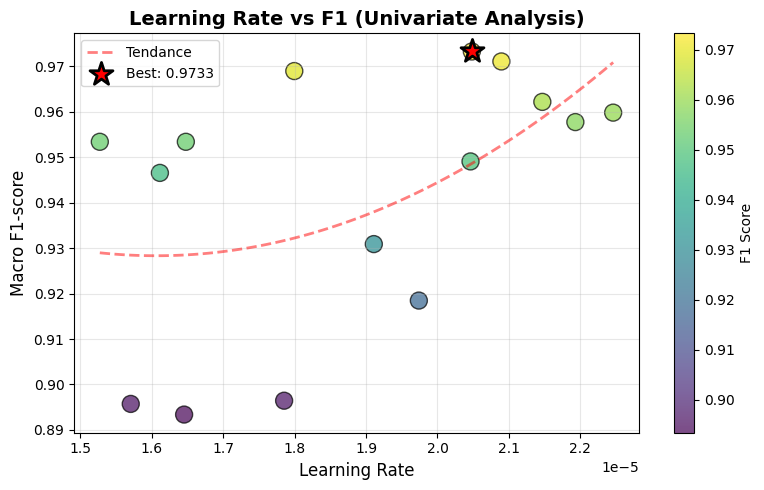

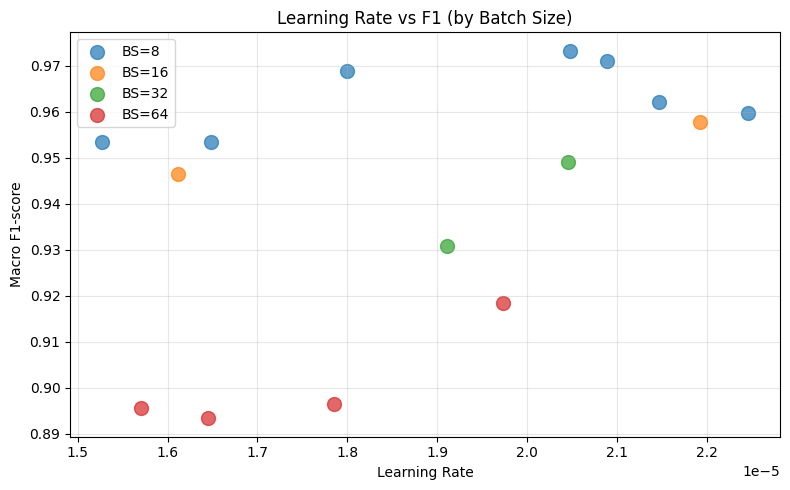

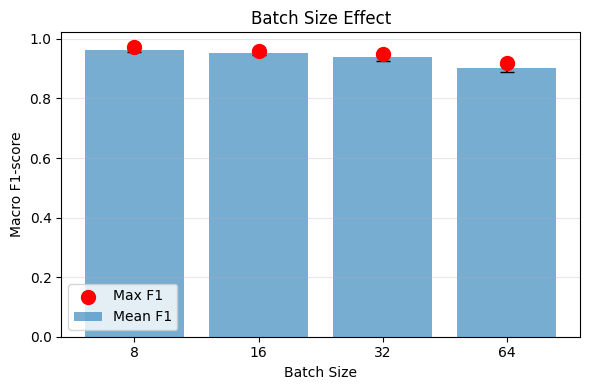

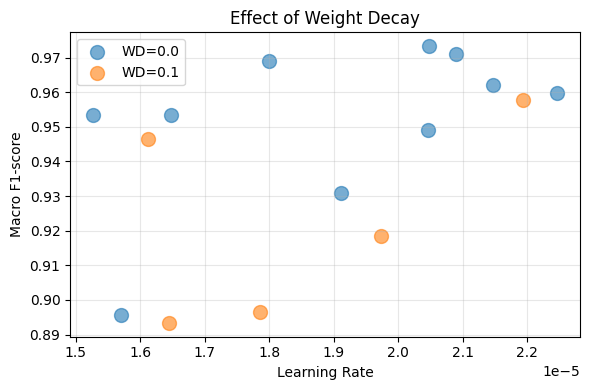

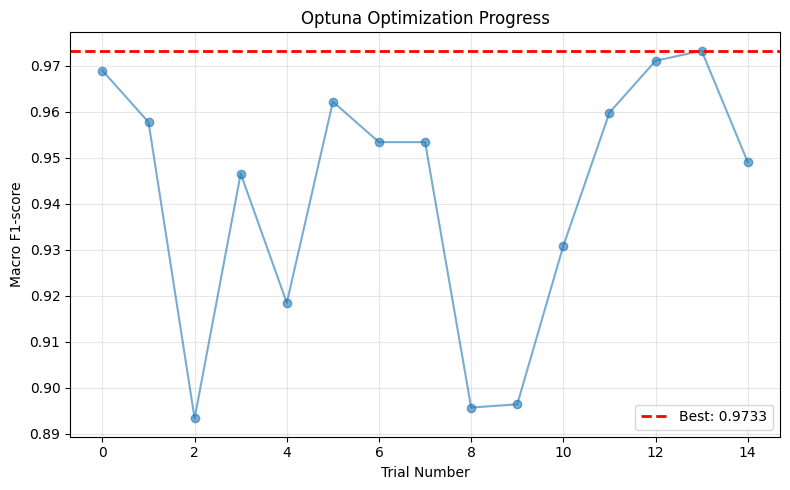


📊 Top 5 configurations:
    trial_number  learning_rate  batch_size  weight_decay  f1_macro     state
13            13       0.000020           8           0.0  0.973279  COMPLETE
12            12       0.000021           8           0.0  0.971087  COMPLETE
0              0       0.000018           8           0.0  0.968972  COMPLETE
5              5       0.000021           8           0.0  0.962190  COMPLETE
11            11       0.000022           8           0.0  0.959821  COMPLETE


In [39]:
!pip install optuna
import optuna
import numpy as np
import torch
from sklearn.metrics import f1_score
from transformers import (
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification
)
import pandas as pd
import json

# -------------------------
# METRIC FUNCTION
# -------------------------
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"eval_f1_macro": f1_score(p.label_ids, preds, average="macro")}

# -------------------------
# OPTUNA OBJECTIVE
# -------------------------
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float("learning_rate", 1.5e-5, 2.3e-5)
    wd = trial.suggest_categorical("weight_decay", [0.0, 0.1])
    bs = trial.suggest_categorical("batch_size", [8, 16, 32, 64])
    ep = 4

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        "roberta-base",
        num_labels=2
    )

    # Training args
    training_args = TrainingArguments(
        output_dir=f"./optuna_trial_{trial.number}",
        learning_rate=lr,
        num_train_epochs=ep,
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=32,
        weight_decay=wd,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=500,
        report_to="none",
        disable_tqdm=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        data_collator=DataCollatorWithPadding(tokenizer),
    )

    trainer.train()
    result = trainer.evaluate()
    f1 = result["eval_f1_macro"]

    # SAUVEGARDE pour plots après
    trial.set_user_attr("f1_macro", f1)
    trial.set_user_attr("trial_number", trial.number)

    # Cleanup
    del model
    del trainer
    torch.cuda.empty_cache()

    return f1

# -------------------------
# RUN OPTUNA
# -------------------------
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(objective, n_trials=15, show_progress_bar=True)

# -------------------------
# SAUVEGARDE COMPLÈTE
# -------------------------
results_list = []
for trial in study.trials:
    results_list.append({
        "trial_number": trial.number,
        "learning_rate": trial.params["learning_rate"],
        "batch_size": trial.params["batch_size"],
        "weight_decay": trial.params["weight_decay"],
        "f1_macro": trial.user_attrs.get("f1_macro", None),
        "state": trial.state.name
    })

results_df = pd.DataFrame(results_list)
results_df.to_csv("optuna_results.csv", index=False)

# Sauvegarder JSON
with open("optuna_study.json", "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value": study.best_value,
        "best_trial": study.best_trial.number,
        "n_trials": len(study.trials),
        "all_trials": results_list
    }, f, indent=2)

print("\n✅ Résultats sauvegardés!")

# -------------------------
# RESULTS
# -------------------------
print("\n" + "="*50)
print(f"Best F1 Score: {study.best_value:.4f}")
print(f"Best Hyperparameters: {study.best_params}")
print("="*50)

# -------------------------
# VISUALIZATIONS
# -------------------------
import matplotlib.pyplot as plt

# Plot 0: UNIVARIÉ - Learning Rate vs F1 (NOUVEAU)
plt.figure(figsize=(8,5))
plt.scatter(results_df["learning_rate"], results_df["f1_macro"],
            s=150, alpha=0.7, c=results_df["f1_macro"],
            cmap='viridis', edgecolors='black', linewidth=1)
plt.colorbar(label='F1 Score')

# Ajouter une ligne de tendance
z = np.polyfit(results_df["learning_rate"], results_df["f1_macro"], 2)
p = np.poly1d(z)
lr_range = np.linspace(results_df["learning_rate"].min(),
                       results_df["learning_rate"].max(), 100)
plt.plot(lr_range, p(lr_range), "r--", alpha=0.5, linewidth=2, label='Tendance')

# Marquer le meilleur
best_row = results_df.loc[results_df["f1_macro"].idxmax()]
plt.scatter(best_row["learning_rate"], best_row["f1_macro"],
            s=300, marker='*', color='red', edgecolors='black',
            linewidth=2, label=f'Best: {best_row["f1_macro"]:.4f}', zorder=10)

plt.xlabel("Learning Rate", fontsize=12)
plt.ylabel("Macro F1-score", fontsize=12)
plt.title("Learning Rate vs F1 (Univariate Analysis)", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("lr_vs_f1_univariate.pdf")
plt.show()

# Plot 1: Learning Rate vs F1 par batch size
plt.figure(figsize=(8,5))
for bs in sorted(results_df["batch_size"].unique()):
    subset = results_df[results_df["batch_size"] == bs]
    plt.scatter(subset["learning_rate"], subset["f1_macro"],
                label=f"BS={bs}", s=100, alpha=0.7)
plt.xlabel("Learning Rate")
plt.ylabel("Macro F1-score")
plt.title("Learning Rate vs F1 (by Batch Size)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("lr_bs_vs_f1.pdf")
plt.show()

# Plot 2: Batch Size effect
plt.figure(figsize=(6,4))
bs_stats = results_df.groupby("batch_size")["f1_macro"].agg(["mean", "max", "std"])
x = bs_stats.index.astype(str)
plt.bar(x, bs_stats["mean"], alpha=0.6, label="Mean F1", yerr=bs_stats["std"], capsize=5)
plt.scatter(x, bs_stats["max"], color="red", s=100, label="Max F1", zorder=5)
plt.xlabel("Batch Size")
plt.ylabel("Macro F1-score")
plt.title("Batch Size Effect")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig("batch_size_effect.pdf")
plt.show()

# Plot 3: Weight Decay
plt.figure(figsize=(6,4))
for wd in sorted(results_df["weight_decay"].unique()):
    subset = results_df[results_df["weight_decay"] == wd]
    plt.scatter(subset["learning_rate"], subset["f1_macro"],
                label=f"WD={wd}", s=100, alpha=0.6)
plt.xlabel("Learning Rate")
plt.ylabel("Macro F1-score")
plt.title("Effect of Weight Decay")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("weight_decay_effect.pdf")
plt.show()

# Plot 4: Optimization history
plt.figure(figsize=(8,5))
plt.plot(results_df["trial_number"], results_df["f1_macro"],
         marker="o", alpha=0.6, linewidth=1.5)
plt.axhline(y=study.best_value, color='r', linestyle='--',
            linewidth=2, label=f'Best: {study.best_value:.4f}')
plt.xlabel("Trial Number")
plt.ylabel("Macro F1-score")
plt.title("Optuna Optimization Progress")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("optimization_history.pdf")
plt.show()

# Top 5
print("\n📊 Top 5 configurations:")
print(results_df.sort_values("f1_macro", ascending=False).head())

In [42]:
import wandb
import numpy as np
from sklearn.metrics import f1_score
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

# -----------------------------------
# 1. Start W&B run
# -----------------------------------
wandb.init(
    project="polarization_nlp_competition",
    name="baseline_run",
    config={
        "learning_rate": 4e-5,
        "epochs": 5,
        "batch_size_train": 8,
        "batch_size_eval": 8
    }
)

# -----------------------------------
# 2. Define compute_metrics
# -----------------------------------
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    f1_macro = f1_score(p.label_ids, preds, average="macro")
    print(f"Macro F1 (current evaluation): {f1_macro:.4f}")  # <-- Affiche à chaque évaluation
    return {"f1_macro": f1_macro}

# -----------------------------------
# 3. TrainingArguments
# -----------------------------------
training_args = TrainingArguments(
    output_dir="./",
    num_train_epochs=5,
    learning_rate=4e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_steps=100,
    eval_strategy="epoch",   # ou "steps" si tu veux evaluer plus souvent
    report_to="wandb",
    run_name="baseline_run",
    save_strategy="epoch"
)

# -----------------------------------
# 4. Trainer
# -----------------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer),
)

# -----------------------------------
# 5. Train
# -----------------------------------
trainer.train()

# -----------------------------------
# 6. Evaluate final
# -----------------------------------
eval_results = trainer.evaluate()
print("Final Macro F1 on validation set:", eval_results["eval_f1_macro"])

# -----------------------------------
# 7. Finish W&B run
# -----------------------------------
wandb.finish()


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.190200,0.001462,1.000000
2,0.117900,0.011093,0.997776
3,0.050200,0.015009,0.997771
4,0.056000,0.000067,1.000000
5,0.026700,0.000034,1.000000


Macro F1 (current evaluation): 1.0000
Macro F1 (current evaluation): 0.9978
Macro F1 (current evaluation): 0.9978
Macro F1 (current evaluation): 1.0000
Macro F1 (current evaluation): 1.0000


Macro F1 (current evaluation): 1.0000
Final Macro F1 on validation set: 1.0


eval/f1_macro,█▁▁███
eval/loss,▂▆█▁▁▁
eval/runtime,█▁▁▁▁▁
eval/samples_per_second,▁█████
eval/steps_per_second,▁█████
train/epoch,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇█████
train/global_step,▁▁▂▂▂▂▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇█████
train/grad_norm,▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/loss,██▆▅▃▅▅▄▃▃▃▂▂▃▂▂▁▁▁▂
eval/f1_macro,1


In [35]:
# Récupérer les logits
pred_output = trainer.predict(dev_dataset)
logits = pred_output.predictions
predictions = np.argmax(logits, axis=-1)

# Récupérer les IDs depuis le dataset
ids = dev['id'].tolist()  # Fixed: Get IDs from the original DataFrame

# Créer un DataFrame au format attendu
submission_df = pd.DataFrame({
    'id': ids,
    'polarization': predictions
})

# Vérifier les premières lignes
print(submission_df.head())

import os
os.makedirs("subtask_1", exist_ok=True)

# Sauvegarder le CSV
submission_df.to_csv("subtask_1/pred_eng.csv", index=False)

import shutil

# Zipper le dossier


                                     id  polarization
0  eng_f66ca14d60851371f9720aaf4ccd9b58             0
1  eng_3a489aa7fed9726aa8d3d4fe74c57efb             0
2  eng_95770ff547ea5e48b0be00f385986483             0
3  eng_2048ae6f9aa261c48e6d777bcc5b38bf             1
4  eng_07781aa88e61e7c0a996abd1e5ea3a20             0


In [36]:
val_pred_output = trainer.predict(val_dataset)
val_logits = val_pred_output.predictions
val_predictions = np.argmax(val_logits, axis=-1)

# Get true labels from the val DataFrame
true_labels = val['polarization'].tolist()

# Find indices where prediction does not match true label
incorrect_indices = [i for i, (pred, true) in enumerate(zip(val_predictions, true_labels)) if pred != true]

# Display the 'bad predictions' from the validation set
bad_df = val.iloc[incorrect_indices].copy()
bad_df['predicted_polarization'] = val_predictions[incorrect_indices]
print("Bad Predictions on the Validation Set:")
#print(bad_predictions_df)

Bad Predictions on the Validation Set:


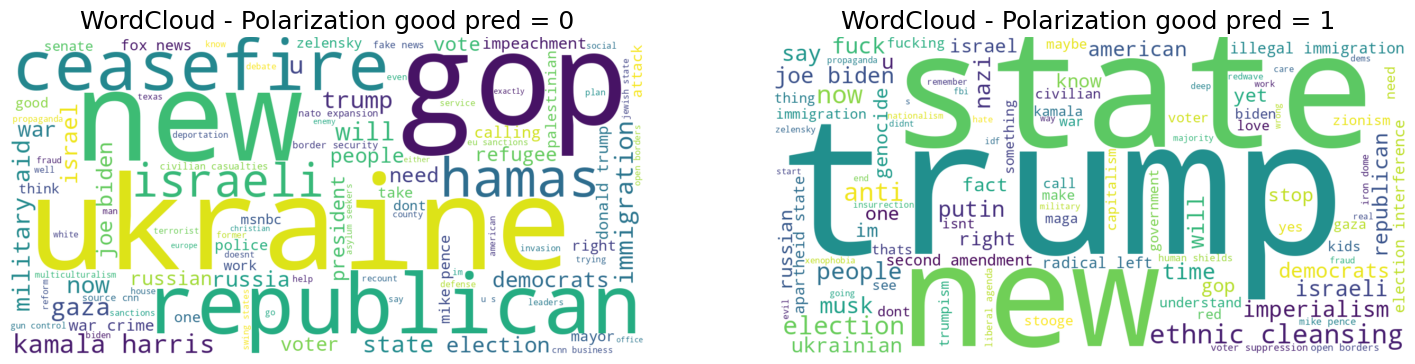

In [37]:
# Identify good predictions from the validation set
correct_indices = [i for i, (pred, true) in enumerate(zip(val_predictions, true_labels)) if pred == true]
good_df = val.iloc[correct_indices].copy()

# ---- 2. Split text by polarization class for good predictions ----
text_0_good = " ".join(good_df[good_df["polarization"] == 0]['text'].dropna())
text_1_good = " ".join(good_df[good_df["polarization"] == 1]['text'].dropna())

# ---- 3. Generate word clouds for good predictions ----
wc0_good = WordCloud(width=1200, height=600, background_color="white", max_words=100).generate(text_0_good)
wc1_good = WordCloud(width=1200, height=600, background_color="white", max_words=100).generate(text_1_good)

# ---- 4. Plot side by side ----
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc0_good, interpolation="bilinear")
plt.title("WordCloud - Polarization good pred = 0", fontsize=18)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wc1_good, interpolation="bilinear")
plt.title("WordCloud - Polarization good pred = 1", fontsize=18)
plt.axis("off")

plt.show()

In [38]:
# ---- 2. Split text by polarization class ----
text_0 = " ".join(bad_df[bad_df["polarization"] == 0]['text'].dropna())
text_1 = " ".join(bad_df[bad_df["polarization"] == 1]['text'].dropna())

# ---- 3. Generate word clouds ----
wc0 = WordCloud(width=1200, height=600, background_color="white", max_words=100).generate(text_0)
wc1 = WordCloud(width=1200, height=600, background_color="white", max_words=100).generate(text_1)

# ---- 4. Plot side by side ----
plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.imshow(wc0, interpolation="bilinear")
plt.title("WordCloud - Polarization bad pred = 0", fontsize=18)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wc1, interpolation="bilinear")
plt.title("WordCloud - Polarization bad pred = 1", fontsize=18)
plt.axis("off")

plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [ ]:
# requirements: pip install pandas scikit-learn nltk
import pandas as pd
import re
from collections import Counter
import math
import nltk
nltk.download('punkt')
nltk.download('punkt_tab') # Add this line to download the missing resource
from nltk.tokenize import word_tokenize

# load
df = bad_df  # columns: id,text,polarization,predicted_polarization

# Tokenize the text and create a 'tokens' column
df['tokens'] = df['text'].apply(word_tokenize)

# split sets
fp = df[(df['polarization']==0) & (df['predicted_polarization']==1)]  # false positives
fn = df[(df['polarization']==1) & (df['predicted_polarization']==0)]  # false negatives
tp = df[(df['polarization']==1) & (df['predicted_polarization']==1)]
tn = df[(df['polarization']==0) & (df['predicted_polarization']==0)]

# count tokens
def count_tokens(rows):
    c = Counter()
    for toks in rows['tokens']:
        c.update(toks)
    return c

cnt_fp = count_tokens(fp)
cnt_fn = count_tokens(fn)
cnt_all = count_tokens(df)

# compute log-odds for FP vs rest
def top_log_odds(target_count, other_count, min_count=5, topk=40):
    vocab = set(list(target_count.keys()) + list(other_count.keys()))
    scores = []
    for w in vocab:
        t = target_count.get(w, 0) + 0.5
        o = other_count.get(w, 0) + 0.5
        if t + o < min_count:
            continue
        lod = math.log((t/(sum(target_count.values()) - t)) / (o/(sum(other_count.values()) - o)))
        scores.append((w, lod, t, o))
    return sorted(scores, key=lambda x: -abs(x[1]))[:topk]

# compare FP vs non-FP
other_fp = cnt_all.copy()
for k,v in cnt_fp.items(): other_fp[k] -= v

top_fp = top_log_odds(cnt_fp, other_fp, min_count=3, topk=40)
top_fn = top_log_odds(cnt_fn, other_fp, min_count=3, topk=40)

print("Top tokens associated with FALSE POSITIVES (model predicts polarized but gt not):")
for w, lod, t, o in top_fp[:30]:
    print(f"{w}\tlogodds={lod:.2f}\tcnt_fp={t}\tcnt_other={o}")

print("\nTop tokens associated with FALSE NEGATIVES (model predicts not polarized but gt polarized):")
for w, lod, t, o in top_fn[:30]:
    print(f"{w}\tlogodds={lod:.2f}\tcnt_fn={t}\tcnt_other={o}")

**Option 0**

4️⃣ Recommandation pragmatique

Rester sur Roberta ou RoBERTa-large / DeBERTa-v3-large.

Ajouter features + dataset augmenté :

Subjectivity / sentiment / sarcasm detection

Anonymisation des entités (ukraine, putin, democrats)

Contre-exemples émotionnels non polarisés

Réentraîner avec class_weights / focal loss pour corriger déséquilibre.

Si après ça le modèle reste limité sur nuances, tester DeBERTa-v3-large pour plus de contexte et meilleure compréhension du langage subtil.

💡 Point clé : changer de modèle n’est pas la priorité. La priorité est d’améliorer la compréhension du contexte et la sensibilité à l’opinion vs fait, ce qui se fait par données + features + fine-tuning ciblé.

**Option 1**

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(df["text"].tolist(), show_progress_bar=True)


In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=8, metric='euclidean')
clusters = clusterer.fit_predict(embeddings)

df["cluster"] = clusters
df.head()


In [ ]:
for c in sorted(df["cluster"].unique()):
    print("\n============== CLUSTER", c, "==============")
    cluster_df = df[df["cluster"] == c]
    print(cluster_df["text"].head(10).to_string(index=False))


In [ ]:
from wordcloud import WordCloud

for c in sorted(df["cluster"].unique()):
    texts = " ".join(df[df["cluster"] == c]["text"].tolist())
    wc = WordCloud(width=800, height=400).generate(texts)

    plt.figure(figsize=(10,4))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"WordCloud – Cluster {c}")
    plt.show()


**Option 2**

🧠 Option 2

Je te génère un class weight + focal loss
→ corrige “atrocity bias”

⚙️ Option 3

Je crée un dataset d’augmentation ciblé
→ pro-Ukraine, anti-GOP, anti-Biden, sarcasme…


Plutôt que supprimer par fréquence brute, préfère :

Ignorer les stopwords standards (langue adaptée).

Limiter les tokens ultra-fréquents (apparaissant dans presque tous les docs) via max_df.

Retirer les tokens ultra-rares (bruit) via min_df.

Utiliser TF-IDF ou pondération pour diminuer l’influence des mots génériques sans les supprimer.

Sélection de caractéristiques supervisée (chi², mutual info) pour garder les tokens qui discriminent entre polarisé/non.

Contrôler via validation : comparer performance avant/après la suppression.

In [ ]:
!pip install lime
from lime.lime_text import LimeTextExplainer

class_names = ["non_polarized", "polarized"]
explainer = LimeTextExplainer(class_names=class_names)

exp = explainer.explain_instance(
    samples[0],
    predict_proba,
    num_features=10
)

exp.show_in_notebook(text=True)


In [ ]:
bad_predictions_df.to_csv('bad_predictions.csv', index=False)
print('bad_predictions.csv has been created.')

In [ ]:
stop

In [ ]:
ids = data["id"].tolist()  # Get IDs from the original DataFrame used to create val_dataset

df = pd.DataFrame({
    "id": ids,
    "prediction": predictions
})

df.to_csv("submission.csv", index=False)
print("Fichier submission.csv prêt.")

# Subtask 2: Polarization Type Classification
Multi-label classification to identify the target of polarization as one of the following categories: Gender/Sexual, Political, Religious, Racial/Ethnic, or Other.
For this task we will load the data for subtask 2.

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/subtask2/train/eng.csv')
val = pd.read_csv('/content/drive/MyDrive/subtask2/train/eng.csv')
train.head()

In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item


In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create train and Test dataset for multilabel
train_dataset = PolarizationDataset(train['text'].tolist(), train[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer)
dev_dataset = PolarizationDataset(val['text'].tolist(), val[['gender/sexual','political','religious','racial/ethnic','other']].values.tolist(), tokenizer)


In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5, problem_type="multi_label_classification") # 5 labels

In [ ]:
# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 2: {eval_results['eval_f1_macro']}")

# Subtask 3: Manifestation Identification
Multi-label classification to classify how polarization is expressed, with multiple possible labels including Vilification, Extreme Language, Stereotype, Invalidation, Lack of Empathy, and Dehumanization.



In [ ]:
train = pd.read_csv('/content/drive/MyDrive/subtask3/train/eng.csv')
val = pd.read_csv('/content/drive/MyDrive/subtask3/train/eng.csv')

train.head()

In [ ]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length # Store max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

In [ ]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Create train and Test dataset for multilabel
train_dataset = PolarizationDataset(train['text'].tolist(), train[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer)
val_dataset = PolarizationDataset(val['text'].tolist(), val[['vilification','extreme_language','stereotype','invalidation','lack_of_empathy','dehumanization']].values.tolist(), tokenizer)

In [ ]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, problem_type="multi_label_classification") # use 6 labels

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)

# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    # Sigmoid the predictions to get probabilities
    probs = torch.sigmoid(torch.from_numpy(p.predictions))
    # Convert probabilities to predicted labels (0 or 1)
    preds = (probs > 0.5).int().numpy()
    # Compute macro F1 score
    return {'f1_macro': f1_score(p.label_ids, preds, average='macro')}

In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_multilabel,  # Use the new metrics function
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 3: {eval_results['eval_f1_macro']}")